In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png


In [4]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png'

In [5]:
df.density.value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [6]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10011/220375232.png,0


In [7]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

In [8]:
df.iloc[0:2,:]

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/10006/1459541791.png,0


# Ensembler

In [9]:
def ensembler(df, no_of_ensembles):
    # Class count
    count_class_0, count_class_1 = df.cancer.value_counts()
    
    # Divide by class
    df_class_0 = df[df['cancer'] == 0]
    df_class_1 = df[df['cancer'] == 1]
    
    # Undersample 0-class
    df_class_0_under = df_class_0.sample(count_class_1*no_of_ensembles, random_state=1)
    
    #ensembling logic
    dfs=[]
    dfs_class_0=[]
    start = 0
    end = count_class_1
    for ensemble in range(no_of_ensembles):
        dfs_class_0.append(df_class_0_under.iloc[start:end,:])
        df_temp = pd.concat([df_class_0_under.iloc[start:end,:], df_class_1], axis=0)
        df_temp = df_temp.sample(frac = 1)
        dfs.append(df_temp)
        start = start + count_class_1
        end = end + count_class_1
    
    return dfs, df_class_1

In [10]:
dfs, df_class_1 = ensembler(df, 5)

In [11]:
len(dfs)

5

In [12]:
dfs[0].cancer.value_counts()

1    1158
0    1158
Name: cancer, dtype: int64

In [13]:
dfs[2].head()

,filepath,cancer
37349,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/50078/474211829.png,1
36585,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/49248/671845054.png,0
38609,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/51562/1009697582.png,0
52732,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/7780/512684699.png,1
39925,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/53155/1540312203.png,0


# Training

In [14]:
def get_learner(dls, arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate,
            accuracy,
            F1Score()
        ],
        #loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,50]).float()),
        pretrained=True,
        #normalize=False
    ).to_fp16()
    return learner

In [15]:
def ensembler_training(dfs, lr, epochs):
    learns=[]
    dls=[]
    for i,df in enumerate(dfs):
        print('starting training of ensemble ', i)
        db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

        dls.append(db.dataloaders(df.values, num_workers=0, bs=32))
        
        dls[i].show_batch(max_n=16)
        
        learns.append(get_learner(dls[i], 'tf_efficientnetv2_s'))
        
        learns[i].fit_one_cycle(epochs, lr)
        
        filepath='ens_512_ch_enetv2_s_ft'+str(i)
        learns[i].save(filepath, with_opt=False)
        
    return learns

In [16]:
learns=[]

starting training of ensemble  0


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.675508,0.650365,0.382289,0.617711,0.646707,01:00
1,0.641247,0.662676,0.377970,0.622030,0.661509,00:56
2,0.504739,1.030247,0.470842,0.529158,0.310127,00:56
3,0.335200,0.844085,0.390929,0.609071,0.600442,00:56
4,0.196417,0.871171,0.384449,0.615551,0.635246,00:57
5,0.142069,0.872913,0.375810,0.624190,0.629787,00:57


starting training of ensemble  1


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.698937,0.660562,0.386609,0.613391,0.558025,01:06
1,0.676352,0.685765,0.438445,0.561555,0.461538,00:57
2,0.545485,0.752444,0.406048,0.593952,0.598291,00:57
3,0.378984,0.941387,0.416847,0.583153,0.606925,00:57
4,0.237255,0.941021,0.414687,0.585313,0.593220,00:57
5,0.163971,0.954935,0.414687,0.585313,0.573333,00:57


starting training of ensemble  2


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.693202,0.747673,0.503240,0.496760,0.114068,01:06
1,0.653734,0.690084,0.421166,0.578834,0.573304,00:57
2,0.519804,0.763813,0.414687,0.585313,0.512690,00:57
3,0.350373,0.885721,0.377970,0.622030,0.637681,00:58
4,0.213589,0.885537,0.382289,0.617711,0.620985,00:58
5,0.141558,0.902595,0.384449,0.615551,0.607930,00:57


starting training of ensemble  3


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.691262,0.710587,0.470842,0.529158,0.351190,01:07
1,0.657926,0.704675,0.393089,0.606911,0.672662,00:58
2,0.524213,0.836316,0.393089,0.606911,0.650000,00:58
3,0.346599,0.930340,0.397408,0.602592,0.572093,00:57
4,0.202938,1.037683,0.397408,0.602592,0.587444,00:58
5,0.134873,1.028362,0.397408,0.602592,0.591111,00:57


starting training of ensemble  4


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.701186,0.656114,0.408207,0.591793,0.597015,01:06
1,0.669830,0.668480,0.393089,0.606911,0.634538,00:58
2,0.564530,0.801961,0.373650,0.626350,0.717781,00:58
3,0.387695,0.800458,0.362851,0.637149,0.695652,00:58
4,0.233012,0.837707,0.406048,0.593952,0.585903,00:57
5,0.155476,0.841737,0.390929,0.609071,0.593258,00:57


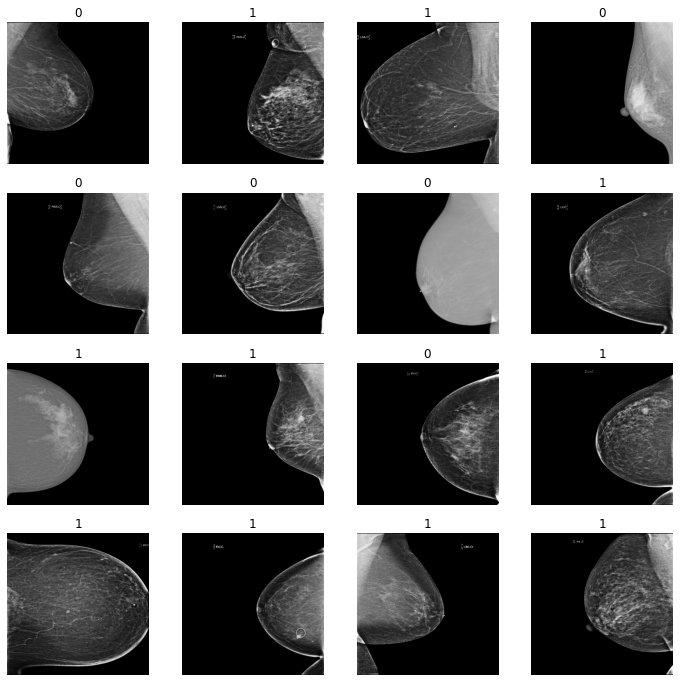

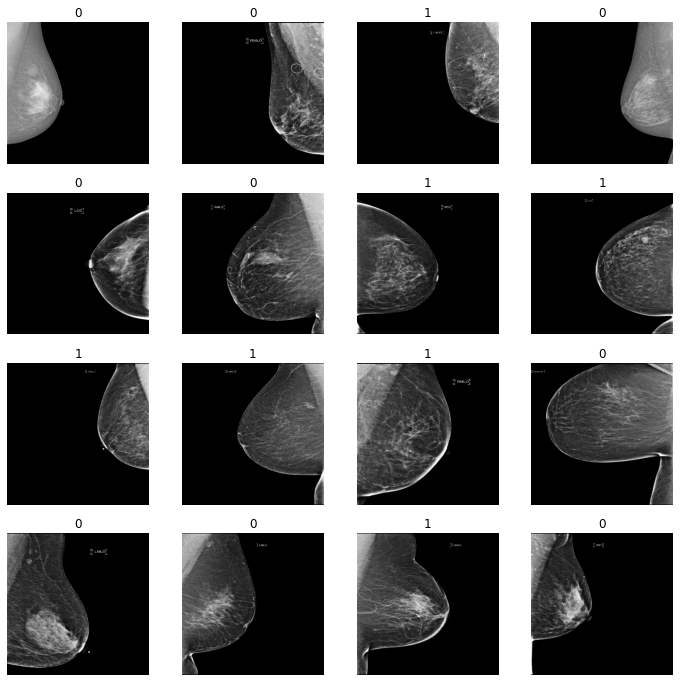

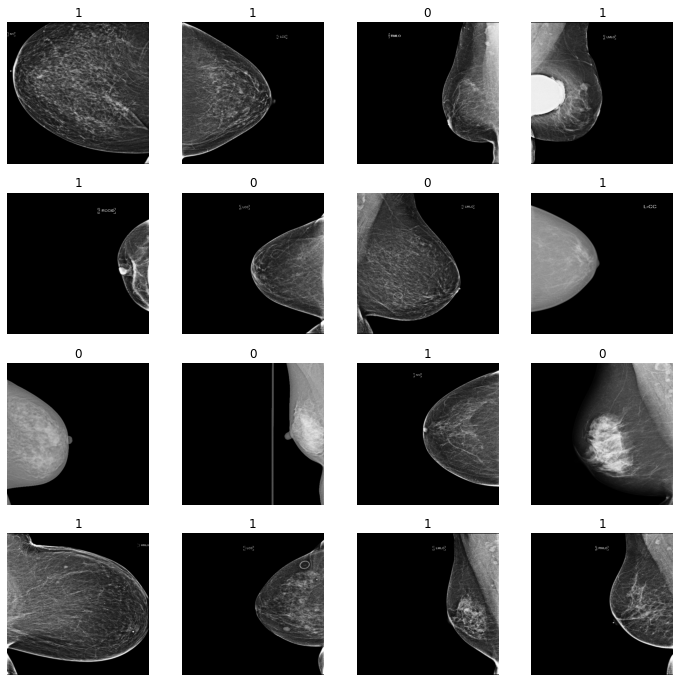

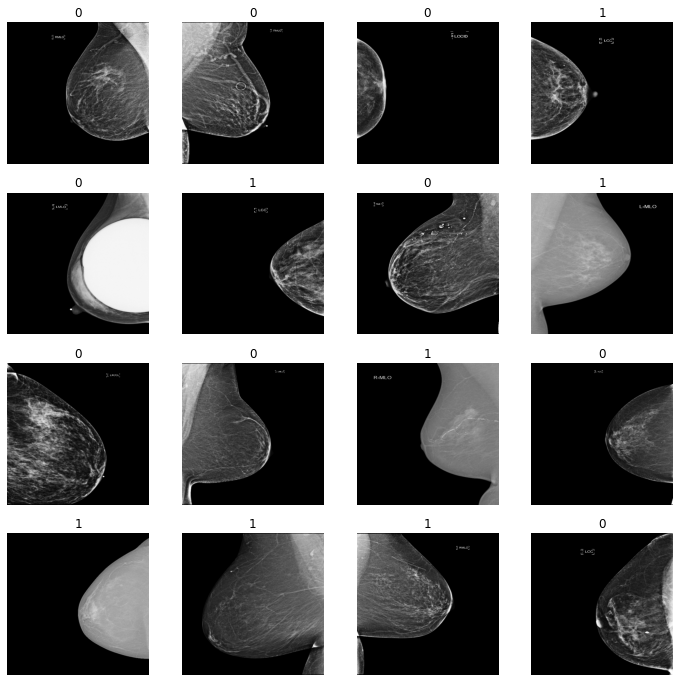

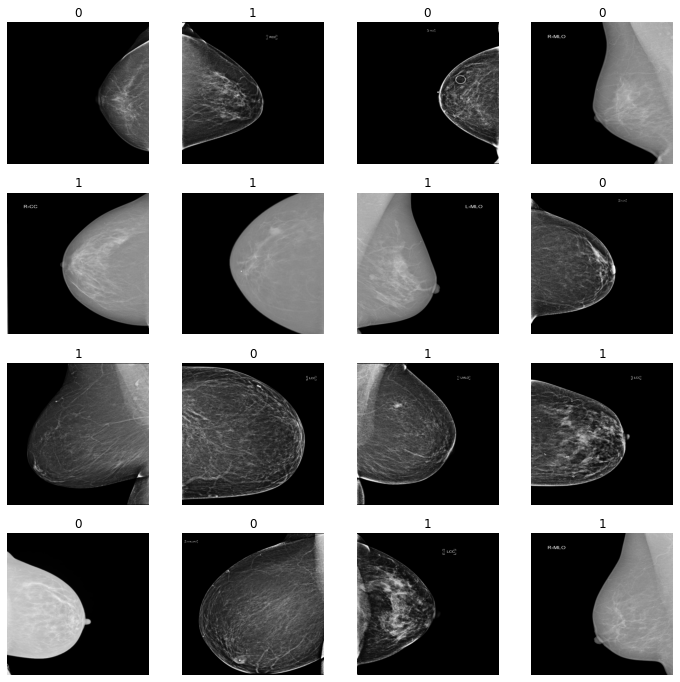

In [17]:
learns = ensembler_training(dfs, 0.005, 6)